## circulator 3-port symmetric - before optimization

In [1]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

Snet = EmNetwork()
#x_arg = np.array([0.4555229716520039, 0.3869410306474232, 5.0855106885089905])
#x_arg = [0.47683284457478003, 3.496795925534134, 6.071444263860713]
#x_arg = [0.3877899877899878, 0.0, 3.747360290328495/2.0]
x_arg = [-1.0/3.0, 0.0, 0.0]
print('x_arg: ', x_arg)
x_abs = x_arg[0]
t_x = x_arg[1]
t_y = x_arg[2]
x = x_abs*exp(1j*t_x)
   
def get3PJuncScattMat(x, t_y):
    y = (1.0/sqrt(2.0)*sqrt(1.0-abs(x)**2))*exp(1j*t_y)
    def f_z(z_ri):
        z = z_ri[0] + 1j*z_ri[1]
        w = -x.conjugate()*exp(2.0j*t_y) - z
        f_1 = abs(z)**2 + abs(w)**2 + abs(y)**2 - 1.0
        f_2 = 2.0*(z*(w.conjugate())).real + abs(y)**2
        return [f_1, f_2]
    res = optimize.root(f_z, [0.0, 0.0], method='broyden2', tol=1.0e-6, options={'maxiter':3000, 'maxfev':3000})
    z = res.x[0] + 1j*res.x[1]
    w = -x.conjugate()*exp(2.0j*t_y) - z
    if res.success==False:
        raise ValueError('res.success==False...')
    smat = np.array([[x, y, y],
                     [y, z, w],
                     [y, w, z]])
    return smat

S_junc = get3PJuncScattMat(x, t_y)

"""
S_junc = np.array([[-1.0/3,  2.0/3,  2.0/3],
                   [2.0/3,  -1.0/3,  2.0/3],
                   [2.0/3,   2.0/3, -1.0/3]])
"""

Z_c = 50
Z_1_Zc = 1.0
S_junc = TL_Tjunc_Smat(Z_c, Z_1_Zc*Z_c)    ##


print('S_j: \n', S_junc)
print('abs(S_j): \n', np.abs(S_junc))

for i in range(S_junc.shape[1]):
    for j in range(S_junc.shape[1]):
        print(abs(S_junc[:,i].T.conjugate().dot(S_junc[:,j])),)
    print



phi_p = 2.0*pi/3.0
phi_m = 1.0*pi/3.0

S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                   [cmath.exp(-1j*phi_p), 0]])

Snet.addComponent(S_junc, "junction", 3)
Snet.addComponent(S_phaser, "phaser", 3)

S = Snet.getTotalScatteringMatrix()

Snet.addConnection("junction_0", 1, "phaser_0", 0)
Snet.addConnection("junction_0", 2, "phaser_2", 1)

Snet.addConnection("junction_1", 1, "phaser_1", 0)
Snet.addConnection("junction_1", 2, "phaser_0", 1)

Snet.addConnection("junction_2", 1, "phaser_2", 0)
Snet.addConnection("junction_2", 2, "phaser_1", 1)

S = Snet.getTotalScatteringMatrix()
print('S = \n', S)
print('abs(S) = \n', np.abs(S))

for i in range(S.shape[1]):
    for j in range(S.shape[1]):
        print(abs(S[:,i].T.conj().dot(S[:,j])),)
    print

print('unitary: ', np.linalg.norm(np.eye(3) - S.dot(S.T.conj())))

S_circ = np.array([[0.0, 0.0, 1.0],
                   [1.0, 0.0, 0.0],
                   [0.0, 1.0, 0.0]])
cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))

print('cond: ', cond)

print('S_dB: \n', 20.0*np.log10(np.abs(S)))

Z1_Zc = 2.0*(1+S_junc[0,0])/(1.0-S_junc[0,0])
print('Z1/Zc = ', Z1_Zc)
print('t_y = ', t_y*180.0/pi)

phi_p += t_y
phi_m += t_y
print('alpha_1 - 2*alpha_2:', ((phi_p-2.0*phi_m)%(2.0*pi))/pi, 'pi')
print('2*alpha_1 - alpha_2:', ((2.0*phi_p-phi_m)%(2.0*pi))/pi, 'pi')


x_arg:  [-0.3333333333333333, 0.0, 0.0]
S_j: 
 [[-0.33333333  0.66666667  0.66666667]
 [ 0.66666667 -0.33333333  0.66666667]
 [ 0.66666667  0.66666667 -0.33333333]]
abs(S_j): 
 [[ 0.33333333  0.66666667  0.66666667]
 [ 0.66666667  0.33333333  0.66666667]
 [ 0.66666667  0.66666667  0.33333333]]
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
S = 
 [[ -1.94289029e-16 +2.42861287e-16j  -1.38777878e-16 -4.44089210e-16j
   -5.00000000e-01 -8.66025404e-01j]
 [ -5.00000000e-01 -8.66025404e-01j  -1.66533454e-16 +2.96707103e-16j
   -5.55111512e-17 -3.88578059e-16j]
 [ -1.38777878e-16 -2.22044605e-16j  -5.00000000e-01 -8.66025404e-01j
   -2.77555756e-16 +2.28116137e-16j]]
abs(S) = 
 [[  3.11014198e-16   4.65268230e-16   1.00000000e+00]
 [  1.00000000e+00   3.40247699e-16   3.92523115e-16]
 [  2.61845577e-16   1.00000000e+00   3.59268938e-16]]
1.0
2.96759446273e-16
5.03052170499e-16
2.96759446273e-16
1.0
6.03643581993e-16
5.03052170499e-16
6.03643581993e-16
1.0
unitary:  1.77800775927e-15
cond:  3.3514130829

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:31: OptimizeWarning: Unknown solver options: maxfev


### optimization part (looking for lossless reciprocal junction that would result to a circulator s-matrix)

The optimization tries to find the scattering matrix of the lossless junction for which the proposed circulator which already satisfies the phase condition can be matched. The best output produces the smallest deviation from an ideal circulator network.

In [12]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

def f_circ(x_arg):
    Snet = EmNetwork()
    
    x_abs = x_arg[0]
    t_x = x_arg[1]
    t_y = x_arg[2]
    x = x_abs*exp(1j*t_x)
    
    x_big = 100.0
    
    if abs(x)>1.0:
        return x_big
    def get3PJuncScattMat(x, t_y):
        y = (1.0/sqrt(2.0)*sqrt(1.0-abs(x)**2))*exp(1j*t_y)
        def f_z(z_ri):
            z = z_ri[0] + 1j*z_ri[1]
            w = -x.conjugate()*exp(2.0j*t_y) - z
            f_1 = abs(z)**2 + abs(w)**2 + abs(y)**2 - 1.0
            f_2 = 2.0*(z*w.conjugate()).real + abs(y)**2
            return [f_1, f_2]
        res = optimize.root(f_z, [0.0, 0.0], method='lm', tol=1.0e-4, options={'maxiter':3000, 'maxfev':3000})
        z = res.x[0] + 1j*res.x[1]
        w = -x.conjugate()*exp(2.0j*t_y) - z
        if res.success==False:
            if abs(res.fun[0]+1j*res.fun[1])>5.0e-2:
                print 'x_arg: ', x_arg
                print 'tol error: ', abs(res.fun[0]+1j*res.fun[1])
                return [False, np.eye(3)]
                raise ValueError('res.success==False...')
        smat = np.array([[x, y, y],
                         [y, z, w],
                         [y, w, z]])
        return [True, smat]
    
    success, S_junc = get3PJuncScattMat(x, t_y)
    if success==False:
        return x_big
    
    phi_p = 2.0*pi/3.0
    phi_m = 1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
    
    #S = Snet.getTotalScatteringMatrix()
    
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))
    #cond = abs(np.linalg.norm(S - S_circ))
    return cond

from Electromagnetics.Misc import *
tic()

"""
methods = {1:'TNC', 2:'L-BFGS-B', 3:'SLSQP', 4:'Powell', 5:'Nelder-Mead', 6:'Anneal', 7:'trust-ncg', 8:'dogleg', 
           9:'COBYLA',10:'CG', 11:'BFGS', 12:'Newton-CG'}
options = {'maxiter':10000, 'disp':True}
res = optimize.minimize(f_circ, [0.30751677,  0.13521282, 2.0*pi-1.86661562], method=methods[12], 
                        bounds=[(0.0, 1.0), (0.0, 2.0*pi), (0.0, 2.0*pi)], options=options, jac=False)
print res
"""

"""
res = optimize.brute(f_circ, ranges=[(0.0, 1.0), (0.0, 2.0*pi), (0.0, 2.0*pi)], Ns=20, full_output=False, finish=optimize.fmin)
print 'res: \n', res.tolist()
print 'f_circ: ', f_circ(res.tolist())
"""


from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.4, 0.6), (3.496795925534134-0.3, 3.496795925534134+0.3), (6.071444263860713-0.3, 2.0*pi)], n_bits=[10, 12, 12], pop_size=500, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)

print("Processing time:", toc())


Start of evolution
-- End of (successful) evolution --
Best individual is [0.45395894428152495, 3.404854533592742, 6.248444401186266], (0.71985719121137048,)
res: 
[[0.45395894428152495, 3.404854533592742, 6.248444401186266], 0.71985719121137048]
Processing time: 0:15:24


The following code uses 2*t_y - t_x as the input variable instead of using two variables t_x and t_y. t_x is fixed.

In [22]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

def f_circ(x_arg):
    Snet = EmNetwork()
    
    x_abs = x_arg[0]
    t2_y_m_t_x = x_arg[1]    ## 2*t_y - t_x
    t_x = 0
    t_y = (t2_y_m_t_x + t_x)/2.0
    x = x_abs*exp(1j*t_x)
    
    x_big = 100.0
    
    if abs(x)>1.0:
        return x_big
    def get3PJuncScattMat(x, t_y):
        y = (1.0/sqrt(2.0)*sqrt(1.0-abs(x)**2))*exp(1j*t_y)
        def f_z(z_ri):
            z = z_ri[0] + 1j*z_ri[1]
            w = -x.conjugate()*exp(2.0j*t_y) - z
            f_1 = abs(z)**2 + abs(w)**2 + abs(y)**2 - 1.0
            f_2 = 2.0*(z*w.conjugate()).real + abs(y)**2
            return [f_1, f_2]
        res = optimize.root(f_z, [0.0, 0.0], method='lm', tol=1.0e-4, options={'maxiter':3000, 'maxfev':3000})
        z = res.x[0] + 1j*res.x[1]
        w = -x.conjugate()*exp(2.0j*t_y) - z
        if res.success==False:
            if abs(res.fun[0]+1j*res.fun[1])>5.0e-2:
                print 'x_arg: ', x_arg
                print 'tol error: ', abs(res.fun[0]+1j*res.fun[1])
                return [False, np.eye(3)]
                raise ValueError('res.success==False...')
        smat = np.array([[x, y, y],
                         [y, z, w],
                         [y, w, z]])
        return [True, smat]
     
    success, S_junc = get3PJuncScattMat(x, t_y)
    if success==False:
        return x_big
    
    phi_p = 2.0*pi/3.0
    phi_m = 1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
    
    #S = Snet.getTotalScatteringMatrix()
    
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))
    #cond = abs(np.linalg.norm(S - S_circ))
    return cond

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 1.0), (0.0, 2.0*pi)], n_bits=[12, 14], pop_size=500, n_gen=1000,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print 'res: \n', res

print "Processing time:", toc()


Start of evolution
x_arg:  [0.8879120879120879, 4.636739935530806]
tol error:  0.386357799761
x_arg:  [0.9663003663003663, 0.605192358831068]
tol error:  0.0680601363847
x_arg:  [0.8879120879120879, 4.636739935530806]
tol error:  0.386357799761
x_arg:  [0.8879120879120879, 4.636739935530806]
tol error:  0.386357799761
-- End of (successful) evolution --
Best individual is [0.3877899877899878, 3.747360290328495], (0.0010655613273113278,)
res: 
[[0.3877899877899878, 3.747360290328495], 0.0010655613273113278]
Processing time: 0:30:43


the following code sets t_x=t_y=0 and only varies abs(x)

In [16]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

def f_circ(x_arg, vbose=False):
    Snet = EmNetwork()
    
    x_abs = x_arg[0]
    t_x = 0.0
    t_y = 0.0
    x = x_abs*exp(1j*t_x)
    
    x_big = 100.0
    
    if abs(x)>1.0:
        return x_big
    def get3PJuncScattMat(x, t_y):
        y = (1.0/sqrt(2.0)*sqrt(1.0-abs(x)**2))*exp(1j*t_y)
        def f_z(z_ri):
            z = z_ri[0] + 1j*z_ri[1]
            w = -x.conjugate()*exp(2.0j*t_y) - z
            f_1 = abs(z)**2 + abs(w)**2 + abs(y)**2 - 1.0
            f_2 = 2.0*(z*(w.conjugate())).real + abs(y)**2
            return [f_1, f_2]
        res = optimize.root(f_z, [0.0, 0.0], method='lm', tol=1.0e-6, options={'maxiter':3000, 'maxfev':3000})
        z = res.x[0] + 1j*res.x[1]
        w = -x.conjugate()*exp(2.0j*t_y) - z
        if res.success==False:
            if abs(res.fun[0]+1j*res.fun[1])>5.0e-2:
                print 'x_arg: ', x_arg
                print 'tol error: ', abs(res.fun[0]+1j*res.fun[1])
                return [False, np.eye(3)]
                raise ValueError('res.success==False...')
        smat = np.array([[x, y, y],
                         [y, z, w],
                         [y, w, z]])
        return [True, smat]
     
    success, S_junc = get3PJuncScattMat(x, t_y)
    if success==False:
        return x_big
    
    if vbose:
        print 'S_junction: \n', S_junc
        print 'abs(S_junction): \n', np.abs(S_junc)
        for i in range(S_junc.shape[1]):
            for j in range(S_junc.shape[1]):
                print abs(S_junc[:,i].T.conjugate().dot(S_junc[:,j])),
            print
    
    phi_p = x_arg[1]    #2.0*pi/3.0
    phi_m = x_arg[2]    #1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    if vbose:
        print 'S_phaser: \n', S_phaser
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
        
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))
    #cond = abs(np.sum(np.abs(S - S_circ)))
    #cond = abs(np.linalg.norm(S - S_circ))

    if vbose:
        print '--'*50
        print 'S: \n', S
        print 'abs(S): \n', np.abs(S)
        print 'S_dB: \n', 20.0*np.log10(np.abs(S))
        for i in range(S.shape[1]):
            for j in range(S.shape[1]):
                print abs(S[:,i].T.conj().dot(S[:,j])),
            print
        print '--'*50
        print 'cond: ', cond
        print 'alpha_1 - 2*alpha_2:', ((phi_p-2.0*phi_m)%(2.0*pi))/pi
        print '2*alpha_1 - alpha_2:', ((2.0*phi_p-phi_m)%(2.0*pi))/pi
        Z1_Zc = 2.0*(1+S_junc[0,0])/(1.0-S_junc[0,0])
        print 'Z1/Zc = ', Z1_Zc
        print 'phi_p = ', phi_p, '  ', phi_p*180/pi, 'deg' 
        print 'phi_m = ', phi_m, '  ', phi_m*180/pi, 'deg'
        print 'exp(-I*phi_p) = ', exp(-1j*phi_p)
        print 'exp(-I*phi_m) = ', exp(-1j*phi_m)
    
    return cond

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 0.99), (0.0, 2.0*pi), (0.0, 2.0*pi)], n_bits=[2,14,14], pop_size=200, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print 'res: \n', res
print "Processing time:", toc()

print '-'*50
f_circ(res[0], True)


Start of evolution
-- End of (successful) evolution --
Best individual is [0.6599999999999999, 0.7739405450704026, 1.0519915337602153], (0.0026787268322055373,)
res: 
[[0.6599999999999999, 0.7739405450704026, 1.0519915337602153], 0.0026787268322055373]
Processing time: 0:01:38
--------------------------------------------------
S_junction: 
[[ 0.6600000+0.j          0.5312250+0.j          0.5312250+0.j        ]
 [ 0.5312250+0.j          0.1367674-0.17924338j -0.7967674+0.17924338j]
 [ 0.5312250+0.j         -0.7967674+0.17924338j  0.1367674-0.17924338j]]
abs(S_junction): 
[[ 0.66        0.531225    0.531225  ]
 [ 0.531225    0.22546289  0.81668016]
 [ 0.531225    0.81668016  0.22546289]]
1.0 2.77555756156e-17 0.0
2.77555756156e-17 1.0 5.55111512313e-17
0.0 5.55111512313e-17 1.0
S_phaser: 
[[ 0.00000000+0.j          0.49584256-0.86841243j]
 [ 0.71516195-0.69895879j  0.00000000+0.j        ]]
---------------------------------------------------------------------------------------------------

0.0026787268322055373

getting the junction layout using optimization

In [3]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
import numpy as np

S_input =np.array(
[[ 0.6600000+0.j,          0.5312250+0.j,          0.5312250+0.j        ],
 [ 0.5312250+0.j,          0.1367674-0.17924338j, -0.7967674+0.17924338j],
 [ 0.5312250+0.j,         -0.7967674+0.17924338j,  0.1367674-0.17924338j]])

def f_junc(x_arg, vbose=False):
    Snet = EmNetwork()
    
    Z_c = 50
    
    theta_x = x_arg[0]
    theta_y0 = x_arg[1]    #between main junc and stup
    theta_y1 = x_arg[2]    #between stub and out port
    theta_s = x_arg[3]    #stub length
    Z_1_Zc = x_arg[4]    #branch char imp
    Z_s_Zc = x_arg[5]    #stub char imp

    S_tx = TL_Smat(theta_x)
    S_junc_0 = TL_Tjunc_Smat(Z_c, Z_1_Zc*Z_c)
    S_ty0 = TL_Smat(theta_y0)
    S_junc_stub = TL_Tjunc_Smat(Z_s_Zc*Z_c, Z_1_Zc*Z_c)
    S_ts = TL_Smat(theta_s, Z_s_Zc*Z_c, 'open')
    S_ty1 = TL_Smat(theta_y1)
    
    Snet.addComponent(S_tx, "tx")
    Snet.addComponent(S_junc_0, "junc_0")
    Snet.addComponent(S_ty0, "ty0", 2)
    Snet.addComponent(S_junc_stub, "junc_st", 2)
    Snet.addComponent(S_ts, "ts", 2)
    Snet.addComponent(S_ty1, "ty1", 2)
    
    Snet.addConnection("tx", 1, "junc_0", 0)
    Snet.addConnection("junc_0", 1, "ty0_0", 0)
    Snet.addConnection("junc_0", 2, "ty0_1", 0)
    Snet.addConnection("ty0_0", 1, "junc_st_0", 1)
    Snet.addConnection("ty0_1", 1, "junc_st_1", 1)
    Snet.addConnection("junc_st_0", 0, "ts_0", 0)
    Snet.addConnection("junc_st_1", 0, "ts_1", 0)
    Snet.addConnection("junc_st_0", 2, "ty1_0", 0)
    Snet.addConnection("junc_st_1", 2, "ty1_1", 0)
    
    S = Snet.getTotalScatteringMatrix()
    
    if vbose:
        import math
        print('S_input = \n', S_input)
        print('S_input_abs = \n', np.abs(S_input))
        print('S_input_phase = \n', np.angle(S_input, deg=True))
        print('S = \n', S)
        print('S_abs = \n', np.abs(S))
        print('S_phase = \n', np.angle(S, deg=True))
        print('S-S_input_abs = \n', np.abs(S-S_input))
        print('S_tx = \n', S_tx)
        print('S_tx_abs = \n', np.abs(S_tx))
        print('S_tx_phase = \n', np.angle(S_tx, deg=True))
        print('S_junc0 = \n', S_junc_0)
        print('S_junc0_abs = \n', np.abs(S_junc_0))
        print('S_junc0_phase = \n', np.angle(S_junc_0, deg=True))
        print('S_ty0 = \n', S_ty0)
        print('S_ty0_abs = \n', np.abs(S_ty0))
        print('S_ty0_phase = \n', np.angle(S_ty0, deg=True))
        print('S_junc_stub = \n', S_junc_stub)
        print('S_junc_stub_abs = \n', np.abs(S_junc_stub))
        print('S_junc_stub_phase = \n', np.angle(S_junc_stub, deg=True))
        print('S_ts = \n', S_ts)
        print('S_ts_abs = \n', np.abs(S_ts))
        print('S_ts_phase = \n', np.angle(S_ts, deg=True))
        print('S_ty1 = \n', S_ty1)
        print('S_ty1_abs = \n', np.abs(S_ty1))
        print('S_ty1_phase = \n', np.angle(S_ty1, deg=True))
        print('theta_x = ', theta_x , '  =  ' , theta_x*180/math.pi, '  deg')
        print('theta_y0 = ', theta_y0 , '  =  ' , theta_y0*180/math.pi, '  deg')
        print('theta_y1 = ', theta_y1 , '  =  ' , theta_y1*180/math.pi, '  deg')
        print('theta_s = ', theta_s , '  =  ' , theta_s*180/math.pi, '  deg')
        print('Z1_Z_c = ', Z_1_Zc)
        print('Zs_Zc = ', Z_s_Zc)
        
    
    cond = abs(np.sum(np.abs(S - S_input)))
    
    return cond


from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *
from math import pi
res = geneticAlg(f_junc, intervals=[(0.0, 2.0*pi), (0.0, 2.0*pi), (0.0, 2.0*pi), (0.0, 2.0*pi), (0.01, 10.0), (0.01, 10.0)], 
                 n_bits=[10,10,10,10,10,10], pop_size=500, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)
print("Processing time:", toc())


param_best = res[0]
#param_best = [4.674001973376017, 6.074359989052406, 1.971556679965442, 2.1558143136070718, 0.45920821114369503, 3.427888563049853]
print('-'*50)
f_junc(param_best, True)


Start of evolution
-- End of (successful) evolution --
Best individual is [4.674001973376017, 1.9039955476301778, 5.9269538821391015, 0.7677401401734587, 0.35178885630498535, 1.357624633431085], (0.017666346607759936,)
res: 
 [[4.674001973376017, 1.9039955476301778, 5.9269538821391015, 0.7677401401734587, 0.35178885630498535, 1.357624633431085], 0.017666346607759936]
Processing time: 0:10:14
--------------------------------------------------
S_input = 
 [[ 0.6600000+0.j          0.5312250+0.j          0.5312250+0.j        ]
 [ 0.5312250+0.j          0.1367674-0.17924338j -0.7967674+0.17924338j]
 [ 0.5312250+0.j         -0.7967674+0.17924338j  0.1367674-0.17924338j]]
S_input_abs = 
 [[ 0.66        0.531225    0.531225  ]
 [ 0.531225    0.22546288  0.81668016]
 [ 0.531225    0.81668016  0.22546288]]
S_input_phase = 
 [[   0.            0.            0.        ]
 [   0.          -52.65541866  167.32162094]
 [   0.          167.32162094  -52.65541866]]
S = 
 [[ 0.65817871+0.00024192j  0.53

0.017666346607759936

Testing the layout junction found in the last code

In [10]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize


"""    
    S_junc = np.array(
[[ 0.65720116-0.05156876j,  0.53110443-0.02533244j,  0.53110443-0.02533244j],
 [ 0.53110443-0.02533244j,  0.14004818-0.16604644j, -0.79917403+0.17726339j],
 [ 0.53110443-0.02533244j, -0.79917403+0.17726339j,  0.14004818-0.16604644j]])                      
"""

def f_circ(vbose=False):
    Snet = EmNetwork()

    S_junc = np.array(
[[ 0.65817871+0.00024192j,  0.53235243+0.00112017j,  0.53235243+0.00112017j],
 [ 0.53235243+0.00112017j,  0.13836214-0.17872198j, -0.79653604+0.17619404j],
 [ 0.53235243+0.00112017j, -0.79653604+0.17619404j,  0.13836214-0.17872198j]])
    
    if vbose:
        print('S_junction: \n', S_junc)
        print('abs(S_junction): \n', np.abs(S_junc))
        for i in range(S_junc.shape[1]):
            for j in range(S_junc.shape[1]):
                print(abs(S_junc[:,i].T.conjugate().dot(S_junc[:,j])), end=" ")
            print()
    
    phi_p = 0.77394054507    #2.0*pi/3.0
    phi_m = 1.05199153376    #1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    if vbose:
        print('S_phaser: \n', S_phaser)
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
        
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])

    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))

    if vbose:
        print('--'*50)
        print('S: \n', S)
        print('abs(S): \n', np.abs(S))
        print('S_dB: \n', 20.0*np.log10(np.abs(S)))
        for i in range(S.shape[1]):
            for j in range(S.shape[1]):
                print(abs(S[:,i].T.conj().dot(S[:,j])), end=" ")
            print('')
        print('--'*50)
        print('cond: ', cond)
        print('phi_p = ', phi_p, '  ', phi_p*180/pi, 'deg')
        print('phi_m = ', phi_m, '  ', phi_m*180/pi, 'deg')
        print('exp(-I*phi_p) = ', exp(-1j*phi_p))
        print('exp(-I*phi_m) = ', exp(-1j*phi_m))
    
    return cond

f_circ(True)


S_junction: 
 [[ 0.65817871+0.00024192j  0.53235243+0.00112017j  0.53235243+0.00112017j]
 [ 0.53235243+0.00112017j  0.13836214-0.17872198j -0.79653604+0.17619404j]
 [ 0.53235243+0.00112017j -0.79653604+0.17619404j  0.13836214-0.17872198j]]
abs(S_junction): 
 [[ 0.65817875  0.53235361  0.53235361]
 [ 0.53235361  0.2260213   0.81579042]
 [ 0.53235361  0.81579042  0.2260213 ]]
1.00000000184 3.00085258933e-09 3.00085259041e-09 
3.00085258933e-09 0.999999995179 6.95868423994e-09 
3.00085259041e-09 6.95868423994e-09 0.999999995179 
S_phaser: 
 [[ 0.00000000+0.j          0.49584256-0.86841243j]
 [ 0.71516195-0.69895879j  0.00000000+0.j        ]]
----------------------------------------------------------------------------------------------------
S: 
 [[ -2.28331503e-03-0.00815286j  -8.93269343e-04-0.00840147j
    9.82792367e-01-0.18432602j]
 [  9.82792367e-01-0.18432602j  -2.28331503e-03-0.00815286j
   -8.93269343e-04-0.00840147j]
 [ -8.93269343e-04-0.00840147j   9.82792367e-01-0.18432602j
   

0.050960799488423761

### T junctions - optimization

the following code uses T junctions S matrix instead of a general unitary S matrix for the junctions

In [2]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

def f_circ(x_arg, vbose=False):
    Snet = EmNetwork()
    
    Z1_Zc = x_arg[0]
    Z_c = 50.0
    S_junc = TL_Tjunc_Smat(Z_c, Z1_Zc*Z_c)
    
    if vbose:
        print('S_junction: \n', S_junc)
        print('abs(S_junction): \n', np.abs(S_junc))
        for i in range(S_junc.shape[1]):
            for j in range(S_junc.shape[1]):
                print(abs(S_junc[:,i].T.conjugate().dot(S_junc[:,j])),)
            print()
    
    phi_p = x_arg[1]    #2.0*pi/3.0
    phi_m = x_arg[2]    #1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    if vbose:
        print('S_phaser: \n', S_phaser)
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
        
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))
    #cond = abs(np.sum(np.abs(S - S_circ)))
    #cond = abs(np.linalg.norm(S - S_circ))

    if vbose:
        print('--'*50)
        print('S: \n', S)
        print('abs(S): \n', np.abs(S))
        print('S_dB: \n', 20.0*np.log10(np.abs(S)))
        for i in range(S.shape[1]):
            for j in range(S.shape[1]):
                print(abs(S[:,i].T.conj().dot(S[:,j])),)
            print()
        print('--'*50)
        print('cond: ', cond)
        print('alpha_1 - 2*alpha_2:', ((phi_p-2.0*phi_m)%(2.0*pi))/pi)
        print('2*alpha_1 - alpha_2:', ((2.0*phi_p-phi_m)%(2.0*pi))/pi)
        print('Z1/Zc = ', Z1_Zc)
        import sympy
        print('phi_p = ', phi_p, '  ', phi_p*180/pi, 'deg', '   ', phi_p/pi, 'rad/pi', '   ', sympy.nsimplify(phi_p/pi, tolerance=0.01), 'rad/pi')
        print('phi_m = ', phi_m, '  ', phi_m*180/pi, 'deg', '   ', phi_m/pi, 'rad/pi', '   ', sympy.nsimplify(phi_m/pi, tolerance=0.01), 'rad/pi')
        print('exp(-I*phi_p) = ', exp(-1j*phi_p))
        print('exp(-I*phi_m) = ', exp(-1j*phi_m))
    
    return cond

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.1, 10.0), (0.0, pi/1.1), (0.0, 2.0*pi)], n_bits=[10,12,12], pop_size=200, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)

print('res: \n', res)
print("Processing time:", toc())

print('-'*50)
f_circ(res[0], True)


time_start:  1.543277
Start of evolution
-- End of (successful) evolution --
Best individual is [0.9806451612903226, 0.03696401612615363, 3.3295511884199516], (0.00034480872183117019,)
res: 
 [[0.9806451612903226, 0.03696401612615363, 3.3295511884199516], 0.00034480872183117019]
time_end:  93.220804
Processing time: 0:01:31
--------------------------------------------------
S_junction: 
 [[-0.34199134  0.66447044  0.66447044]
 [ 0.66447044 -0.32900433  0.67099567]
 [ 0.66447044  0.67099567 -0.32900433]]
abs(S_junction): 
 [[ 0.34199134  0.66447044  0.66447044]
 [ 0.66447044  0.32900433  0.67099567]
 [ 0.66447044  0.67099567  0.32900433]]
1.0
0.0
2.77555756156e-17

0.0
1.0
1.11022302463e-16

2.77555756156e-17
1.11022302463e-16
1.0

S_phaser: 
 [[ 0.00000000+0.j         -0.98238774+0.18685378j]
 [ 0.99931691-0.0369556j   0.00000000+0.j        ]]
----------------------------------------------------------------------------------------------------
S: 
 [[ -5.07366249e-06 +5.72431467e-05j   

0.00034480872183117019

In [7]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
import cmath
from cmath import *
import numpy as np
import scipy as sp
from scipy import optimize

def f_circ(x_arg, vbose=False):
    Snet = EmNetwork()
    
    x_abs = x_arg[0]
    Z1_Zc = 2.0*(1+x_abs)/(1.0-x_abs)
    t_x = 0.0
    t_y = 0.0
    x = x_abs*exp(1j*t_x)
    y = (1.0/sqrt(2.0)*sqrt(1.0-abs(x)**2))*exp(1j*t_y)
    Z1_Z23 = 1.0 + Z1_Zc
    z = (1.0 - Z1_Z23)/(1.0 + Z1_Z23)
    w = -x.conjugate()*exp(2.0j*t_y) - z
    
    S_junc = np.array([[x, y, y],
                       [y, z, w],
                       [y, w, z]])
    
    if vbose:
        print('S_junction: \n', S_junc)
        print('abs(S_junction): \n', np.abs(S_junc))
        for i in range(S_junc.shape[1]):
            for j in range(S_junc.shape[1]):
                print abs(S_junc[:,i].T.conjugate().dot(S_junc[:,j])),
            print
    
    phi_p = x_arg[1]    #2.0*pi/3.0
    phi_m = x_arg[2]    #1.0*pi/3.0
    
    S_phaser = np.array([[0, cmath.exp(-1j*phi_m)],
                       [cmath.exp(-1j*phi_p), 0]])
    
    if vbose:
        print 'S_phaser: \n', S_phaser
    
    Snet.addComponent(S_junc, "junction", 3)
    Snet.addComponent(S_phaser, "phaser", 3)
        
    Snet.addConnection("junction_0", 1, "phaser_0", 0)
    Snet.addConnection("junction_0", 2, "phaser_2", 1)
    
    Snet.addConnection("junction_1", 1, "phaser_1", 0)
    Snet.addConnection("junction_1", 2, "phaser_0", 1)
    
    Snet.addConnection("junction_2", 1, "phaser_2", 0)
    Snet.addConnection("junction_2", 2, "phaser_1", 1)
    
    S = Snet.getTotalScatteringMatrix()
    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond = abs(np.sum(np.abs(np.abs(S) - S_circ)))
    #cond = abs(np.sum(np.abs(S - S_circ)))
    #cond = abs(np.linalg.norm(S - S_circ))

    if vbose:
        print '--'*50
        print 'S: \n', S
        print 'abs(S): \n', np.abs(S)
        print 'S_dB: \n', 20.0*np.log10(np.abs(S))
        for i in range(S.shape[1]):
            for j in range(S.shape[1]):
                print abs(S[:,i].T.conj().dot(S[:,j])),
            print
        print '--'*50
        print 'cond: ', cond
        print 'alpha_1 - 2*alpha_2:', ((phi_p-2.0*phi_m)%(2.0*pi))/pi
        print '2*alpha_1 - alpha_2:', ((2.0*phi_p-phi_m)%(2.0*pi))/pi
        Z1_Zc = 2.0*(1+S_junc[0,0])/(1.0-S_junc[0,0])
        print 'Z1/Zc = ', Z1_Zc
        import sympy
        print 'phi_p = ', phi_p, '  ', phi_p*180/pi, 'deg', '   ', phi_p/pi, 'rad/pi', '   ', sympy.nsimplify(phi_p/pi, tolerance=0.01), 'rad/pi'
        print 'phi_m = ', phi_m, '  ', phi_m*180/pi, 'deg', '   ', phi_m/pi, 'rad/pi', '   ', sympy.nsimplify(phi_m/pi, tolerance=0.01), 'rad/pi'
        print 'exp(-I*phi_p) = ', exp(-1j*phi_p)
        print 'exp(-I*phi_m) = ', exp(-1j*phi_m)
    
    return cond

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 0.99), (0.0, 2.0*pi), (0.0, 2.0*pi)], n_bits=[2,14,14], pop_size=200, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print 'res: \n', res
print "Processing time:", toc()

print '-'*50
f_circ(res[0], True)


 Start of evolution
-- End of (successful) evolution --
Best individual is [0.0, 4.1887902047863905, 5.235412478075354], (2.5714292989279053,)
res: 
[[0.0, 4.1887902047863905, 5.235412478075354], 2.5714292989279053]
Processing time: 0:01:28
--------------------------------------------------
S_junction: 
[[ 0.00000000+0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.50000000+0.j  0.50000000+0.j]
 [ 0.70710678+0.j  0.50000000+0.j -0.50000000+0.j]]
abs(S_junction): 
[[ 0.          0.70710678  0.70710678]
 [ 0.70710678  0.5         0.5       ]
 [ 0.70710678  0.5         0.5       ]]
1.0 0.0 0.0
0.0 1.0 1.11022302463e-16
0.0 1.11022302463e-16 1.0
S_phaser: 
[[ 0.00000000+0.j         0.49950171+0.8663129j]
 [-0.50000000+0.8660254j  0.00000000+0.j       ]]
----------------------------------------------------------------------------------------------------
S: 
[[ 0.42857149 +4.69614967e-05j  0.14259276 +2.47588412e-01j
  -0.42879506 +7.42178252e-01j]
 [-0.42879506 +7.42178252e-01j  0.

2.5714292989279053

## circulator 3-port asymmetric

In [7]:
%reload_ext autoreload
%autoreload

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex
from cmath import *

import numpy as np

Snet = EmNetwork()

"""
S_junc = np.array([[0.0, 1.0/sqrt(2.0), 1.0/sqrt(2.0)],
                  [1.0/sqrt(2.0),  -0.5, 0.5],
                  [1.0/sqrt(2.0),  0.5, -0.5]], dtype=complex)
"""

Z_c = 50
Z_1_Zc = 1.0
S_junc = TL_Tjunc_Smat(Z_c, Z_1_Zc*Z_c)


S_phaser0 = np.array([[0, exp(-1j*pi/2)],
                   [exp(-1j*pi/2), 0]], dtype=complex)
S_phaser1 = np.array([[0.0, -1.0],
                      [1.0, 0.0]], dtype=complex)
S_phaser2 = np.array([[0, exp(-1j*pi/2)],
                   [exp(-1j*pi/2), 0]], dtype=complex)

Snet.addComponent(S_junc, "junction", 3)
Snet.addComponent(S_phaser0, "phaser_0")
Snet.addComponent(S_phaser1, "phaser_1")
Snet.addComponent(S_phaser2, "phaser_2")

S = Snet.getTotalScatteringMatrix()
#print 'sqrt(2)/2: ', sqrt(2.0)/2.0
#print S

Snet.addConnection("junction_0", 1, "phaser_0", 0)
Snet.addConnection("junction_0", 2, "phaser_2", 1)

Snet.addConnection("junction_1", 1, "phaser_1", 0)
Snet.addConnection("junction_1", 2, "phaser_0", 1)

Snet.addConnection("junction_2", 1, "phaser_2", 0)
Snet.addConnection("junction_2", 2, "phaser_1", 1)

S = Snet.getTotalScatteringMatrix()

print(abs(S))

for i in range(S.shape[1]):
    print(S[:,i].T.conj().dot(S[:,i]))



[[  8.26491825e-17   1.00000000e+00   4.13245912e-17]
 [  4.13245912e-17   4.13245912e-17   1.00000000e+00]
 [  1.00000000e+00   1.77433905e-16   4.13245912e-17]]
(1+0j)
(1+0j)
(1+0j)


## magic-T circulator

In [2]:

from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex

import numpy as np
from cmath import *

Snet = EmNetwork()


MT_junc = np.array([[0, 1, 1, 0],
                  [1, 0, 0, 1],
                  [1, 0, 0,-1],
                  [0, 1,-1, 0]], dtype=complex)

MT_junc = 1/sqrt(2.0)*MT_junc


S_gyr = np.array([[0,  1],
                [-1, 0]], dtype=complex)

Snet.addComponent(MT_junc, "magic T", 2)
Snet.addComponent(S_gyr, "gyrator")

S = Snet.getTotalScatteringMatrix()
#print S

Snet.addConnection("magic T_0", 2, "gyrator", 1)
Snet.addConnection("magic T_1", 2, "gyrator", 0)
Snet.addConnection("magic T_0", 1, "magic T_1", 1)


S = Snet.getTotalScatteringMatrix()

print S

for i in range(S.shape[1]):
    print S[:,i].T.conj().dot(S[:,i])


[[ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]]
(1+0j)
(1+0j)
(1+0j)
(1+0j)


### Plotting results

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


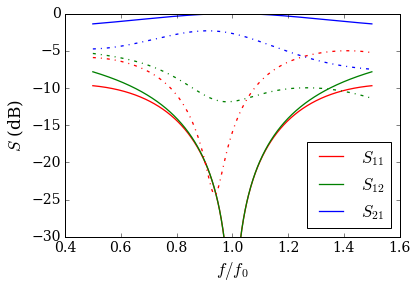

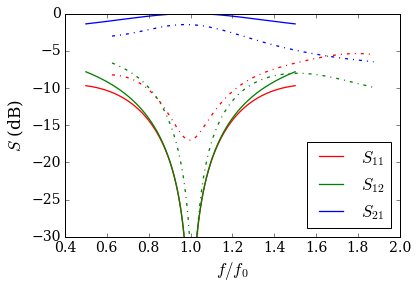

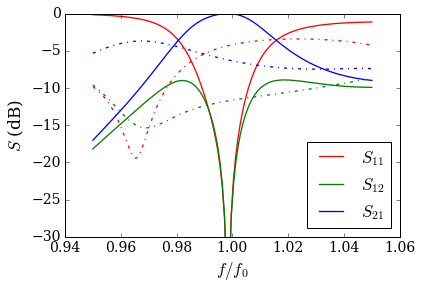

In [31]:
%pylab inline
from numpy import genfromtxt
import os

file_ext = '.eps'
dir_name = 'other/circulator/symmetric'
lw = 1.3
lab_font=17
pad=0.0

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
matplotlib.rc('font', **font)

data_11 = genfromtxt(os.path.join(dir_name, 'S11_cir.txt'),  skip_header=1)
data_21 = genfromtxt(os.path.join(dir_name, 'S21_cir.txt'),  skip_header=1)
data_12 = genfromtxt(os.path.join(dir_name, 'S12_cir.txt'),  skip_header=1)

data_f_11 = genfromtxt(os.path.join(dir_name, 'S11_full.txt'),  skip_header=2)
data_f_21 = genfromtxt(os.path.join(dir_name, 'S21_full.txt'),  skip_header=2)
data_f_12 = genfromtxt(os.path.join(dir_name, 'S12_full.txt'),  skip_header=2)


f_0 = 2.0e9
f, s_11 = data_11[:, 0], data_11[:, 1]
f, s_12 = data_12[:, 0], data_12[:, 1]
f, s_21 = data_21[:, 0], data_21[:, 1]

plot(f/f_0, s_11, 'r', linewidth=lw, label='$S_{11}$')
plot(f/f_0, s_12, 'g', linewidth=lw, label='$S_{12}$')
plot(f/f_0, s_21, 'b', linewidth=lw, label='$S_{21}$')

f_0 = 2.0
f, s_11 = data_f_11[:, 0], data_f_11[:, 1]
f, s_12 = data_f_12[:, 0], data_f_12[:, 1]
f, s_21 = data_f_21[:, 0], data_f_21[:, 1]

plot(f/f_0, s_11, 'r-.', linewidth=lw)
plot(f/f_0, s_12, 'g-.', linewidth=lw)
plot(f/f_0, s_21, 'b-.', linewidth=lw)

ylim([-30.0, 0.0])
xlabel('$f/f_0$', fontsize=lab_font)
ylabel('$S$ (dB)', fontsize=lab_font)
legend(loc='lower right')

file_name = os.path.join(dir_name, 'S_symm_cir'+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=pad)
show()


dir_name = 'other/circulator/asymmetric'

data_11 = genfromtxt(os.path.join(dir_name, 'S11_cir.txt'),  skip_header=1)
data_21 = genfromtxt(os.path.join(dir_name, 'S21_cir.txt'),  skip_header=1)
data_12 = genfromtxt(os.path.join(dir_name, 'S12_cir.txt'),  skip_header=1)

data_f_11 = genfromtxt(os.path.join(dir_name, 'S11_full.txt'),  skip_header=2)
data_f_21 = genfromtxt(os.path.join(dir_name, 'S21_full.txt'),  skip_header=2)
data_f_12 = genfromtxt(os.path.join(dir_name, 'S12_full.txt'),  skip_header=2)

f_0 = 2.0e9
f, s_11 = data_11[:, 0], data_11[:, 1]
f, s_12 = data_12[:, 0], data_12[:, 1]
f, s_21 = data_21[:, 0], data_21[:, 1]

plot(f/f_0, s_11, 'r', linewidth=lw, label='$S_{11}$')
plot(f/f_0, s_12, 'g', linewidth=lw, label='$S_{12}$')
plot(f/f_0, s_21, 'b', linewidth=lw, label='$S_{21}$')

f_0 = 1.6
f, s_11 = data_f_11[:, 0], data_f_11[:, 1]
f, s_12 = data_f_12[:, 0], data_f_12[:, 1]
f, s_21 = data_f_21[:, 0], data_f_21[:, 1]

plot(f/f_0, s_11, 'r-.', linewidth=lw)
plot(f/f_0, s_12, 'g-.', linewidth=lw)
plot(f/f_0, s_21, 'b-.', linewidth=lw)

ylim([-30.0, 0.0])
xlabel('$f/f_0$', fontsize=lab_font)
ylabel('$S$ (dB)', fontsize=lab_font)
legend(loc='lower right')

file_name = os.path.join(dir_name, 'S_asym_cir'+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=pad)
show()

dir_name = 'other/circulator/stub'

data_11 = genfromtxt(os.path.join(dir_name, 'S11_cir.txt'),  skip_header=1)
data_21 = genfromtxt(os.path.join(dir_name, 'S21_cir.txt'),  skip_header=1)
data_12 = genfromtxt(os.path.join(dir_name, 'S12_cir.txt'),  skip_header=1)

data_f_11 = genfromtxt(os.path.join(dir_name, 'S11_full.txt'),  skip_header=2)
data_f_21 = genfromtxt(os.path.join(dir_name, 'S21_full.txt'),  skip_header=2)
data_f_12 = genfromtxt(os.path.join(dir_name, 'S12_full.txt'),  skip_header=2)

f_0 = 1.0e9
f, s_11 = data_11[:, 0], data_11[:, 1]
f, s_12 = data_12[:, 0], data_12[:, 1]
f, s_21 = data_21[:, 0], data_21[:, 1]

plot(f/f_0, s_11, 'r', linewidth=lw, label='$S_{11}$')
plot(f/f_0, s_12, 'g', linewidth=lw, label='$S_{12}$')
plot(f/f_0, s_21, 'b', linewidth=lw, label='$S_{21}$')

f_0 = 1.0
f, s_11 = data_f_11[:, 0], data_f_11[:, 1]
f, s_12 = data_f_12[:, 0], data_f_12[:, 1]
f, s_21 = data_f_21[:, 0], data_f_21[:, 1]

plot(f/f_0, s_11, 'r-.', linewidth=lw)
plot(f/f_0, s_12, 'g-.', linewidth=lw)
plot(f/f_0, s_21, 'b-.', linewidth=lw)

ylim([-30.0, 0.0])
xlabel('$f/f_0$', fontsize=lab_font)
ylabel('$S$ (dB)', fontsize=lab_font)
legend(loc='lower right')

file_name = os.path.join(dir_name, 'S_stub_cir'+file_ext)
savefig(file_name, bbox_inches='tight', pad_inches=pad)

show()


### Toshiro's Rat-Race Circulator

In [1]:
## lossless (only phase nonreciprocity)

import numpy as np
from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex

#x, y, z, u, v, w = symbols('x y z u v w')


def f_circ(x_arg, vbose=False):
    S_RR = EmNetwork()

    theta = x_arg[0]

    
    """
    S_junc = np.array([[0, 1/np.sqrt(2.0), 1/np.sqrt(2.0)],
                     [1/np.sqrt(2.0),  -1.0/2, 1.0/2],
                     [1/np.sqrt(2.0),   1.0/2, -1.0/2]])
    """
    
    S_junc = np.array([[-1.0/3,  2.0/3,  2.0/3],
                       [2.0/3,  -1.0/3,  2.0/3],
                       [2.0/3,   2.0/3, -1.0/3]])

    S_tl1 = np.array([[0, np.exp(-1j*theta)],
                     [np.exp(-1j*theta), 0]])
    S_tl2 = np.array([[0, np.exp(-1j*2*theta)],
                     [np.exp(-1j*2*theta), 0]])

    S_fet = np.array([[0, -1.0],
                    [1.0, 0]])


    S_RR.addComponent(S_junc, "junction", 5)
    S_RR.addComponent(S_tl1, "tl1", 4)
    S_RR.addComponent(S_tl2, "tl2")
    S_RR.addComponent(S_fet, "fet")

    S = S_RR.getTotalScatteringMatrix()


    S_RR.addConnection("junction_0", 1, "tl1_0", 0)
    S_RR.addConnection("tl1_0", 1, "junction_1", 2)

    S_RR.addConnection("junction_1", 1, "tl1_1", 0)
    S_RR.addConnection("tl1_1", 1, "junction_2", 2)

    S_RR.addConnection("junction_2", 1, "tl1_2", 0)
    S_RR.addConnection("tl1_2", 1, "junction_3", 2)

    S_RR.addConnection("junction_3", 1, "tl1_3", 0)
    S_RR.addConnection("tl1_3", 1, "junction_4", 2)

    S_RR.addConnection("junction_4", 1, "tl2", 0)
    S_RR.addConnection("tl2", 1, "junction_0", 2)

    S_RR.addConnection("junction_3", 0, "fet", 0)
    S_RR.addConnection("fet", 1, "junction_1", 0)



    S = S_RR.getTotalScatteringMatrix()
    if vbose:
        print('theta/pi: ', theta/np.pi)
        print('S = \n', np.abs(S))
        print('S dB= \n', 20*np.log10(np.abs(S)))
        print('SST* = \n', np.abs(S.dot(np.conjugate(S.T))))

    S_circ = np.array([[0.0, 0.0, 1.0],
                       [1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0]])
    S_circ2 = np.array([[0.0, 1.0, 0.0],
                        [0.0, 0.0, 1.0],
                        [1.0, 0.0, 0.0]])
    
    cond_1 = np.sum(np.abs(np.abs(S) - S_circ))
    cond_2 = np.sum(np.abs(np.abs(S) - S_circ2))
    #cond = abs(np.linalg.norm(S - S_circ))
    return min(cond_1, cond_2)

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 1.0*np.pi)], n_bits=[12], pop_size=100, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)

f_circ(res[0], vbose=True)

print("Processing time:", toc())



time_start:  4957.169191221
Start of evolution
-- End of (successful) evolution --
Best individual is [0.9896592242077736], (1.8658852573768809,)
res: 
 [[0.9896592242077736], 1.8658852573768809]
theta/pi:  0.315018315018315
S = 
 [[ 0.24507238  0.30436312  0.92049042]
 [ 0.92284545  0.23604949  0.30436312]
 [ 0.2971461   0.92284545  0.24507238]]
S dB= 
 [[-12.21411273 -10.33215941  -0.71961451]
 [ -0.69742048 -12.53993862 -10.33215941]
 [-10.54059944  -0.69742048 -12.21411273]]
SST* = 
 [[  1.00000000e+00   3.92523115e-16   3.63282740e-16]
 [  3.92523115e-16   1.00000000e+00   3.51083347e-16]
 [  3.63282740e-16   3.51083347e-16   1.00000000e+00]]
time_end:  5107.693574343
Processing time: 0:02:30


In [2]:
## lossless + additional scatterers at each port (only phase nonreciprocity)

import numpy as np
from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex

#x, y, z, u, v, w = symbols('x y z u v w')


def f_circ(x_arg, vbose=False):
    S_RR = EmNetwork()

    theta = x_arg[0]
    a1 = x_arg[1]
    a2 = x_arg[2]
    a3 = x_arg[3]
    t1 = x_arg[4]
    t2 = x_arg[5]
    t3 = x_arg[6]

    
    """
    S_junc = np.array([[0, 1/np.sqrt(2.0), 1/np.sqrt(2.0)],
                     [1/np.sqrt(2.0),  -1.0/2, 1.0/2],
                     [1/np.sqrt(2.0),   1.0/2, -1.0/2]])
    """
    
    S_junc = np.array([[-1.0/3,  2.0/3,  2.0/3],
                       [2.0/3,  -1.0/3,  2.0/3],
                       [2.0/3,   2.0/3, -1.0/3]])

    S_tl1 = np.array([[0, np.exp(-1j*theta)],
                     [np.exp(-1j*theta), 0]])
    S_tl2 = np.array([[0, np.exp(-1j*2*theta)],
                     [np.exp(-1j*2*theta), 0]])

    S_fet = np.array([[0, -1.0],
                    [1.0, 0]])
    
    a1 *= np.exp(-1j*t1)
    S_T_1 = np.array([[a1, np.sqrt(1.0-np.abs(a1)**2)],
                      [np.sqrt(1.0-np.abs(a1)**2), -np.conjugate(a1)]])
    
    a2 *= np.exp(-1j*t2)
    S_T_2 = np.array([[a2, np.sqrt(1.0-np.abs(a2)**2)],
                      [np.sqrt(1.0-np.abs(a2)**2), -np.conjugate(a2)]])

    a3 *= np.exp(-1j*t3)
    S_T_3 = np.array([[a3, np.sqrt(1.0-np.abs(a3)**2)],
                      [np.sqrt(1.0-np.abs(a3)**2), -np.conjugate(a3)]])


    S_RR.addComponent(S_junc, "junction", 5)
    S_RR.addComponent(S_tl1, "tl1", 4)
    S_RR.addComponent(S_tl2, "tl2")
    S_RR.addComponent(S_fet, "fet")

    S_RR.addComponent(S_T_1, "t_port_1")
    S_RR.addComponent(S_T_2, "t_port_2")
    S_RR.addComponent(S_T_3, "t_port_3")

    
    S = S_RR.getTotalScatteringMatrix()


    S_RR.addConnection("junction_0", 1, "tl1_0", 0)
    S_RR.addConnection("tl1_0", 1, "junction_1", 2)

    S_RR.addConnection("junction_1", 1, "tl1_1", 0)
    S_RR.addConnection("tl1_1", 1, "junction_2", 2)

    S_RR.addConnection("junction_2", 1, "tl1_2", 0)
    S_RR.addConnection("tl1_2", 1, "junction_3", 2)

    S_RR.addConnection("junction_3", 1, "tl1_3", 0)
    S_RR.addConnection("tl1_3", 1, "junction_4", 2)

    S_RR.addConnection("junction_4", 1, "tl2", 0)
    S_RR.addConnection("tl2", 1, "junction_0", 2)

    S_RR.addConnection("junction_3", 0, "fet", 0)
    S_RR.addConnection("fet", 1, "junction_1", 0)

    S_RR.addConnection("junction_0", 0, "t_port_1", 1)
    S_RR.addConnection("junction_2", 0, "t_port_2", 1)
    S_RR.addConnection("junction_4", 0, "t_port_3", 1)



    S = S_RR.getTotalScatteringMatrix()
    if vbose:
        print('theta/pi: ', theta/np.pi)
        print('S = \n', np.abs(S))
        print('S dB= \n', 20*np.log10(np.abs(S)))
        print('S*ST = \n', np.abs(S.dot(np.conjugate(S.T))))
        
        print('S1*S1T = \n', np.abs(S_T_1.dot(np.conjugate(S_T_1.T))))
        print('S2*S3T = \n', np.abs(S_T_2.dot(np.conjugate(S_T_2.T))))
        print('S2*S3T = \n', np.abs(S_T_3.dot(np.conjugate(S_T_3.T))))

    db_scale = True
    cond_1, cond_2 = 100.0, 100.0
    if not db_scale:
        S_circ = np.array([[0.0, 0.0, 1.0],
                           [1.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0]])
        S_circ2 = np.array([[0.0, 1.0, 0.0],
                            [0.0, 0.0, 1.0],
                            [1.0, 0.0, 0.0]])

        cond_1 = np.sum(np.abs(np.abs(S) - S_circ))
        cond_2 = np.sum(np.abs(np.abs(S) - S_circ2))

    else:
        isol = -40
        S_circ_dB = np.array([[isol, isol,  1.0],
                              [ 1.0, isol, isol],
                              [isol,  1.0, isol]])
        S_circ2_dB = np.array([[isol,  1.0, isol],
                               [isol, isol,  1.0],
                               [ 1.0, isol, isol]])
        
        S = (S!=0.0)*S + (S==0.0)*1.0e-12
        S_dB = 20.0*np.log10(np.abs(S))
        S_dB = (S_dB<=isol)*isol + (S_dB>isol)*S_dB

        cond_1 = np.sum(np.abs(S_dB - S_circ_dB))
        cond_2 = np.sum(np.abs(S_dB - S_circ2_dB))

    return min(cond_1, cond_2)

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 1.0*np.pi), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0),\
                 (0.0, 2.0*np.pi), (0.0, 2.0*np.pi), (0.0, 2.0*np.pi)],\
                 n_bits=[12, 10, 10, 10, 10, 10, 10], pop_size=300, n_gen=400,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)

f_circ(res[0], vbose=True)

print("Processing time:", toc())



time_start:  6591.552953427
Start of evolution
-- End of (successful) evolution --
Best individual is [1.0448960181170448, 0.39002932551319647, 0.34995112414467255, 0.39296187683284456, 4.280919021607206, 0.9519977738150889, 4.280919021607206], (3.0001545737960571,)
res: 
 [[1.0448960181170448, 0.39002932551319647, 0.34995112414467255, 0.39296187683284456, 4.280919021607206, 0.9519977738150889, 4.280919021607206], 3.0001545737960571]
theta/pi:  0.33260073260073264
S = 
 [[  3.98480480e-03   5.84023538e-04   9.99991890e-01]
 [  9.99991274e-01   1.25658422e-03   3.98406853e-03]
 [  1.25424744e-03   9.99999040e-01   5.89025255e-04]]
S dB= 
 [[ -4.79918590e+01  -6.46713930e+01  -7.04420627e-05]
 [ -7.57928917e-05  -5.80161680e+01  -4.79934640e+01]
 [ -5.80323355e+01  -8.33884162e-06  -6.45973217e+01]]
S*ST = 
 [[  1.00000000e+00   6.56511515e-16   5.79879652e-16]
 [  6.56511515e-16   1.00000000e+00   6.72591072e-16]
 [  5.79879652e-16   6.72591072e-16   1.00000000e+00]]
S1*S1T = 
 [[ 1.  0

In [5]:
## gain and phase nonreciprocity

import numpy as np
from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex

#x, y, z, u, v, w = symbols('x y z u v w')


def f_circ(x_arg, vbose=False):
    S_RR = EmNetwork()

    theta = x_arg[0]
    alpha = x_arg[1]

    """
    S_junc = Matrix([[0, 1/sqrt(2), 1/sqrt(2)],
                     [1/sqrt(2),  -Rational(1,2), Rational(1,2)],
                     [1/sqrt(2),  Rational(1,2), -Rational(1,2)]])
    """
    
    S_junc = np.array([[-1.0/3,  2.0/3,  2.0/3],
                       [2.0/3,  -1.0/3,  2.0/3],
                       [2.0/3,   2.0/3, -1.0/3]])


    S_tl1 = np.array([[0, np.exp(-1j*theta)],
                     [np.exp(-1j*theta), 0]])
    S_tl2 = np.array([[0, np.exp(-1j*2*theta)],
                     [np.exp(-1j*2*theta), 0]])

    S_fet = np.array([[0, alpha],
                    [1.0, 0]])


    S_RR.addComponent(S_junc, "junction", 5)
    S_RR.addComponent(S_tl1, "tl1", 4)
    S_RR.addComponent(S_tl2, "tl2")
    S_RR.addComponent(S_fet, "fet")

    S = S_RR.getTotalScatteringMatrix()


    S_RR.addConnection("junction_0", 1, "tl1_0", 0)
    S_RR.addConnection("tl1_0", 1, "junction_1", 2)

    S_RR.addConnection("junction_1", 1, "tl1_1", 0)
    S_RR.addConnection("tl1_1", 1, "junction_2", 2)

    S_RR.addConnection("junction_2", 1, "tl1_2", 0)
    S_RR.addConnection("tl1_2", 1, "junction_3", 2)

    S_RR.addConnection("junction_3", 1, "tl1_3", 0)
    S_RR.addConnection("tl1_3", 1, "junction_4", 2)

    S_RR.addConnection("junction_4", 1, "tl2", 0)
    S_RR.addConnection("tl2", 1, "junction_0", 2)

    S_RR.addConnection("junction_3", 0, "fet", 0)
    S_RR.addConnection("fet", 1, "junction_1", 0)



    S = S_RR.getTotalScatteringMatrix()
    if vbose:
        print('S = \n', np.abs(S))
        print('S dB= \n', 20*np.log10(np.abs(S)))
        print('SST* = \n', np.abs(S.dot(np.conjugate(S.T))))

    isol = -15
    S_circ_dB = np.array([[isol, isol,  1.0],
                          [ 1.0, isol, isol],
                          [isol,  1.0, isol]])
    S_circ2_dB = np.array([[isol,  1.0, isol],
                           [isol, isol,  1.0],
                           [ 1.0, isol, isol]])
                           
    S_dB = 20.0*np.log10(np.abs(S))
    S_dB = (S_dB<=isol)*isol + (S_dB>isol)*S_dB
    
    cond_1 = np.sum(np.abs(S_dB - S_circ_dB))
    cond_2 = np.sum(np.abs(S_dB - S_circ2_dB))
    #cond = abs(np.linalg.norm(S - S_circ))
    return min(cond_1, cond_2)

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 2.0*np.pi), (-1.0, 1.0)], n_bits=[10, 10], pop_size=100, n_gen=200,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)

f_circ(res[0], vbose=True)

print("Processing time:", toc())



time_start:  14608.053040207
Start of evolution
-- End of (successful) evolution --
Best individual is [5.282052164393396, -0.8787878787878788], (23.093090163434482,)
res: 
 [[5.282052164393396, -0.8787878787878788], 23.093090163434482]
S = 
 [[ 0.17784132  0.34357063  0.86705908]
 [ 0.86191303  0.20430715  0.34357063]
 [ 0.26992872  0.86191303  0.17784132]]
S dB= 
 [[-14.99934644  -9.27967929  -1.23902616]
 [ -1.29073109 -13.79432868  -9.27967929]
 [-11.37501803  -1.29073109 -14.99934644]]
SST* = 
 [[ 0.90145977  0.0979301   0.1226332 ]
 [ 0.0979301   0.90267626  0.12187389]
 [ 0.1226332   0.12187389  0.84738312]]
time_end:  14721.68739115
Processing time: 0:01:53


In [2]:
## gain and phase nonreciprocity + scatterers at each port

import numpy as np
from Electromagnetics.NetworkAnalysis import *
from IPython.display import display, Math, Latex

#x, y, z, u, v, w = symbols('x y z u v w')


def f_circ(x_arg, vbose=False):
    S_RR = EmNetwork()

    theta = x_arg[0]
    a1 = x_arg[1]
    a2 = x_arg[2]
    a3 = x_arg[3]
    t1 = x_arg[4]
    t2 = x_arg[5]
    t3 = x_arg[6]
    alpha = x_arg[7]

    """
    S_junc = Matrix([[0, 1/sqrt(2), 1/sqrt(2)],
                     [1/sqrt(2),  -Rational(1,2), Rational(1,2)],
                     [1/sqrt(2),  Rational(1,2), -Rational(1,2)]])
    """
    
    S_junc = np.array([[-1.0/3,  2.0/3,  2.0/3],
                       [2.0/3,  -1.0/3,  2.0/3],
                       [2.0/3,   2.0/3, -1.0/3]])


    S_tl1 = np.array([[0, np.exp(-1j*theta)],
                     [np.exp(-1j*theta), 0]])
    S_tl2 = np.array([[0, np.exp(-1j*2*theta)],
                     [np.exp(-1j*2*theta), 0]])

    S_fet = np.array([[0, alpha],
                    [1.0, 0]])


    a1 *= np.exp(-1j*t1)
    S_T_1 = np.array([[a1, np.sqrt(1.0-np.abs(a1)**2)],
                      [np.sqrt(1.0-np.abs(a1)**2), -np.conjugate(a1)]])
    
    a2 *= np.exp(-1j*t2)
    S_T_2 = np.array([[a2, np.sqrt(1.0-np.abs(a2)**2)],
                      [np.sqrt(1.0-np.abs(a2)**2), -np.conjugate(a2)]])

    a3 *= np.exp(-1j*t3)
    S_T_3 = np.array([[a3, np.sqrt(1.0-np.abs(a3)**2)],
                      [np.sqrt(1.0-np.abs(a3)**2), -np.conjugate(a3)]])


    S_RR.addComponent(S_junc, "junction", 5)
    S_RR.addComponent(S_tl1, "tl1", 4)
    S_RR.addComponent(S_tl2, "tl2")
    S_RR.addComponent(S_fet, "fet")

    S_RR.addComponent(S_T_1, "t_port_1")
    S_RR.addComponent(S_T_2, "t_port_2")
    S_RR.addComponent(S_T_3, "t_port_3")

    
    S = S_RR.getTotalScatteringMatrix()


    S_RR.addConnection("junction_0", 1, "tl1_0", 0)
    S_RR.addConnection("tl1_0", 1, "junction_1", 2)

    S_RR.addConnection("junction_1", 1, "tl1_1", 0)
    S_RR.addConnection("tl1_1", 1, "junction_2", 2)

    S_RR.addConnection("junction_2", 1, "tl1_2", 0)
    S_RR.addConnection("tl1_2", 1, "junction_3", 2)

    S_RR.addConnection("junction_3", 1, "tl1_3", 0)
    S_RR.addConnection("tl1_3", 1, "junction_4", 2)

    S_RR.addConnection("junction_4", 1, "tl2", 0)
    S_RR.addConnection("tl2", 1, "junction_0", 2)

    S_RR.addConnection("junction_3", 0, "fet", 0)
    S_RR.addConnection("fet", 1, "junction_1", 0)

    S_RR.addConnection("junction_0", 0, "t_port_1", 1)
    S_RR.addConnection("junction_2", 0, "t_port_2", 1)
    S_RR.addConnection("junction_4", 0, "t_port_3", 1)



    S = S_RR.getTotalScatteringMatrix()
    if vbose:
        print('theta/pi: ', theta/np.pi)
        print('S = \n', np.abs(S))
        print('S dB= \n', 20*np.log10(np.abs(S)))
        print('S*ST = \n', np.abs(S.dot(np.conjugate(S.T))))
        
        print('S1*S1T = \n', np.abs(S_T_1.dot(np.conjugate(S_T_1.T))))
        print('S2*S3T = \n', np.abs(S_T_2.dot(np.conjugate(S_T_2.T))))
        print('S2*S3T = \n', np.abs(S_T_3.dot(np.conjugate(S_T_3.T))))

    isol = -15
    S_circ_dB = np.array([[isol, isol,  1.0],
                          [ 1.0, isol, isol],
                          [isol,  1.0, isol]])
    S_circ2_dB = np.array([[isol,  1.0, isol],
                           [isol, isol,  1.0],
                           [ 1.0, isol, isol]])
                           
    S_dB = 20.0*np.log10(np.abs(S))
    S_dB = (S_dB<=isol)*isol + (S_dB>isol)*S_dB
    
    cond_1 = np.sum(np.abs(S_dB - S_circ_dB))
    cond_2 = np.sum(np.abs(S_dB - S_circ2_dB))
    #cond = abs(np.linalg.norm(S - S_circ))
    return min(cond_1, cond_2)

from Electromagnetics.Misc import *
tic()

from Electromagnetics.EvolAlgs import *

res = geneticAlg(f_circ, intervals=[(0.0, 1.0*np.pi), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0),\
                 (0.0, 2.0*np.pi), (0.0, 2.0*np.pi), (0.0, 2.0*np.pi), (-0.5, 0.5)],\
                 n_bits=[12, 10, 10, 10, 10, 10, 10, 10], pop_size=300, n_gen=400,
                 pr_cross=0.2, pr_mut=0.5, pr_bit_mut=0.1, maximize=False)
print('res: \n', res)

f_circ(res[0], vbose=True)

print("Processing time:", toc())



time_start:  13111.585303982
Start of evolution


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in multiply


-- End of (successful) evolution --
Best individual is [0.8983650787188394, 0.187683284457478, 0.3020527859237537, 0.12609970674486803, 2.4322007640695174, 1.1731069341850449, 1.5477641225896928, -0.5], (26.728550093088192,)
res: 
 [[0.8983650787188394, 0.187683284457478, 0.3020527859237537, 0.12609970674486803, 2.4322007640695174, 1.1731069341850449, 1.5477641225896928, -0.5], 26.728550093088192]
theta/pi:  0.28595848595848594
S = 
 [[ 0.09981349  0.47796179  0.71718793]
 [ 0.75464197  0.17779816  0.42189203]
 [ 0.17801907  0.76782029  0.07153251]]
S dB= 
 [[-20.01621552  -6.41213646  -2.88734059]
 [ -2.44518088 -15.00145459  -7.49597357]
 [-14.99066964  -2.29480829 -22.90993108]]
S*ST = 
 [[ 0.75276873  0.23370059  0.30393512]
 [ 0.23370059  0.77908958  0.2873011 ]
 [ 0.30393512  0.2873011   0.62635569]]
S1*S1T = 
 [[ 1.  0.]
 [ 0.  1.]]
S2*S3T = 
 [[ 1.  0.]
 [ 0.  1.]]
S2*S3T = 
 [[ 1.  0.]
 [ 0.  1.]]
time_end:  14822.491376872
Processing time: 0:28:30
